# Projet 4 : Notebook Prediction


# 1. Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import xgboost

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn import set_config
from sklearn.compose import (ColumnTransformer,
                             TransformedTargetRegressor,
                             make_column_transformer)
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import (LinearRegression,
                                  Lasso,
                                  Ridge,
                                  SGDRegressor,
                                  ElasticNet)
from sklearn.model_selection import (train_test_split,
                                     StratifiedShuffleSplit,
                                     GridSearchCV)
from sklearn.metrics import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.svm import SVR
from tqdm import tqdm
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot

# 2. Class to make predictions

In [79]:
REGRESSORS = [("LinearRegression", LinearRegression),
              ("Ridge", Ridge),
              ("Lasso", Lasso),
              ("ElasticNet", ElasticNet),
              ("SVR", SVR),
              ("XGBRegressor", xgboost.XGBRegressor),
              ("XGRF", xgboost.XGBRFRegressor),
              ("DummyRegressor", DummyRegressor)]


numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

In [80]:
def adjusted_rsquared(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

class Regressors:
    def __init__(
        self,
        verbose=0,
        ignore_warnings=False,
        custom_metric=None,
        predictions=False,
        random_state=42,
        regressors="all",
        params = None
    ):
        self.verbose = verbose
        self.ignore_warnings = ignore_warnings
        self.custom_metric = custom_metric
        self.predictions = predictions
        self.models = {}
        self.random_state = random_state
        self.regressors = regressors
        self.params = params
        print(self.params)

    def fit(self, X_train, X_test, y_train, y_test):
        """Fit Regression algorithms to X_train and y_train, predict and score on X_test, y_test.
        Parameters
        ----------
        X_train : array-like,
            Training vectors, where rows is the number of samples
            and columns is the number of features.
        X_test : array-like,
            Testing vectors, where rows is the number of samples
            and columns is the number of features.
        y_train : array-like,
            Training vectors, where rows is the number of samples
            and columns is the number of features.
        y_test : array-like,
            Testing vectors, where rows is the number of samples
            and columns is the number of features.
        Returns
        -------
        scores : Pandas DataFrame
            Returns metrics of all the models in a Pandas DataFrame.
        predictions : Pandas DataFrame
            Returns predictions of all the models in a Pandas DataFrame.
        """
        R2 = []
        ADJR2 = []
        RMSE = []
        names = []
        TIME = []
        predictions = {}
        pipes = {}

        if self.custom_metric:
            CUSTOM_METRIC = []

        if isinstance(X_train, np.ndarray):
            X_train = pd.DataFrame(X_train)
            X_test = pd.DataFrame(X_test)

        numeric_features = X_train.select_dtypes(include=[np.number]).columns
        categorical_features = X_train.select_dtypes(include=["object"]).columns


        preprocessor = ColumnTransformer(
            transformers=[
                ("numeric", numeric_transformer, numeric_features),
                ("categorical", categorical_transformer, categorical_features),
            ]
        )
        

        if self.regressors == "all":
            self.regressors = REGRESSORS
        else:
            try:
                temp_list = []
                for regressor in self.regressors:
                    full_name = (regressor.__name__, regressor)
                    temp_list.append(full_name)
                self.regressors = temp_list
            except Exception as exception:
                print(exception)
                print("Invalid Regressor(s)")
        print(self.regressors)
        for name, model in tqdm(self.regressors):
            start = time.time()
            try:
                if "random_state" in model().get_params().keys():
                    pipe = Pipeline(
                        steps=[
                            ("preprocessor", preprocessor),
                            ("regressor", model(random_state=self.random_state)),
                        ]
                    )
                elif self.params is not None:
                    pipe = Pipeline(
                        steps=[("preprocessor", preprocessor), ("regressor", model(**self.params))]
                    )
                else:
                    pipe = Pipeline(
                        steps=[("preprocessor", preprocessor), ("regressor", model())]
                    )
                pipe = TransformedTargetRegressor(regressor=pipe, func=np.log, inverse_func=np.exp)
                
                pipe.fit(X_train, y_train)
            
                self.models[name] = pipe
                y_pred = pipe.predict(X_test)
                r_squared = r2_score(y_test, y_pred)
                adj_rsquared = adjusted_rsquared(
                    r_squared, X_test.shape[0], X_test.shape[1]
                )
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                names.append(name)
                R2.append(r_squared)
                ADJR2.append(adj_rsquared)
                RMSE.append(rmse)
                TIME.append(time.time() - start)
                pipes[name] = pipe
                
                if self.custom_metric:
                    custom_metric = self.custom_metric(y_test, y_pred)
                    CUSTOM_METRIC.append(custom_metric)

                if self.verbose > 0:
                    scores_verbose = {
                        "Model": name,
                        "R-Squared": r_squared,
                        "Adjusted R-Squared": adj_rsquared,
                        "RMSE": rmse,
                        "Time taken": time.time() - start,
                    }

                    if self.custom_metric:
                        scores_verbose[self.custom_metric.__name__] = custom_metric

                    print(scores_verbose)
                if self.predictions:
                    predictions[name] = y_pred
            except Exception as exception:
                if self.ignore_warnings is False:
                    print(name + " model failed to execute")
                    print(exception)

        scores = {
            "Model": names,
            "Adjusted R-Squared": ADJR2,
            "R-Squared": R2,
            "RMSE": RMSE,
            "Time Taken": TIME,
        }
        

        if self.custom_metric:
            scores[self.custom_metric.__name__] = CUSTOM_METRIC

        scores = pd.DataFrame(scores)
        scores = scores.sort_values(by="Adjusted R-Squared", ascending=False).reset_index(drop=True)
        best_model = scores['Model'][0]
        scores = scores.set_index(
            "Model"
        )
        best_model_pipe = pipes[best_model]
        scores[["R-Squared", "Adjusted R-Squared"]] = scores[["R-Squared", "Adjusted R-Squared"]].mul(100).round(2)
        return scores, best_model_pipe
    
    
    def feature_importance(self, X_test, y_test, X_train, best_model_pipe):
        importance = permutation_importance(best_model_pipe, X_test, y_test,
                                            n_repeats=30,
                                            random_state=0, 
                                            n_jobs = -1)
        features_names = X_train.columns
        d = {features_names[idx] : importance.importances_mean[idx] for idx in importance.importances_mean.argsort()[::-1]}
        df = pd.DataFrame(d.items(), columns=['feature', 'value'])
    
        df["abs_value"] = df["value"].apply(lambda x: abs(x))
        df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
        df = df.sort_values("abs_value", ascending=False)
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 7))
        fig = sns.barplot(x="feature",
                    y="value",
                    data=df.head(20),
                   palette=df.head(20)["colors"])
        fig = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
        fig = ax.set_title("Feature importance", fontsize=25)
        fig = ax.set_ylabel("Coef", fontsize=22)
        fig = ax.set_xlabel("Feature Name", fontsize=22)
        
        return fig

## 3. Prediction of SiteEnergyUse(kBtu)

### 3.1 Prediction on basic models

#### 3.1.1 Import data and split 

In [81]:
df = pd.read_pickle('data/clean_data.pkl')
df = df[df['SiteEnergyUse(kBtu)']!=0]

categorical_features = df.select_dtypes(include=["object"]).columns
df[categorical_features] = df[categorical_features].astype(str)

X = df.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])
y = df['SiteEnergyUse(kBtu)']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2, random_state = 123)

#### 3.1.2 Train regressors

In [82]:
reg = Regressors(verbose=1, regressors='all')
regressions, best_model_pipe = reg.fit(X_train, X_test, y_train, y_test)

None
[('LinearRegression', <class 'sklearn.linear_model._base.LinearRegression'>), ('Ridge', <class 'sklearn.linear_model._ridge.Ridge'>), ('Lasso', <class 'sklearn.linear_model._coordinate_descent.Lasso'>), ('ElasticNet', <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>), ('SVR', <class 'sklearn.svm._classes.SVR'>), ('XGBRegressor', <class 'xgboost.sklearn.XGBRegressor'>), ('XGRF', <class 'xgboost.sklearn.XGBRFRegressor'>), ('DummyRegressor', <class 'sklearn.dummy.DummyRegressor'>)]


  0%|                                                                   | 0/8 [00:00<?, ?it/s]C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: overflow encountered in exp
  return func(X, **(kw_args if kw_args else {}))
 12%|███████▍                                                   | 1/8 [00:04<00:31,  4.45s/it]

LinearRegression model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').


 38%|██████████████████████▏                                    | 3/8 [00:04<00:05,  1.14s/it]

{'Model': 'Ridge', 'R-Squared': -109.29303435957598, 'Adjusted R-Squared': -118.08450811287551, 'RMSE': 211956627.24561203, 'Time taken': 0.24770307540893555}
{'Model': 'Lasso', 'R-Squared': -0.08354628824734656, 'Adjusted R-Squared': -0.16991591991923638, 'RMSE': 21008579.67188309, 'Time taken': 0.14388060569763184}


 50%|█████████████████████████████▌                             | 4/8 [00:05<00:03,  1.32it/s]

{'Model': 'ElasticNet', 'R-Squared': 0.014535953462215923, 'Adjusted R-Squared': -0.06401552850818715, 'RMSE': 20035184.667164586, 'Time taken': 0.17065048217773438}


 62%|████████████████████████████████████▉                      | 5/8 [00:07<00:04,  1.44s/it]

{'Model': 'SVR', 'R-Squared': 0.3600206786344762, 'Adjusted R-Squared': 0.3090078341778041, 'RMSE': 16145664.67203349, 'Time taken': 2.6495261192321777}


 75%|████████████████████████████████████████████▎              | 6/8 [00:09<00:03,  1.71s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.8789154521127164, 'Adjusted R-Squared': 0.8692637852521359, 'RMSE': 7022913.509422015, 'Time taken': 2.215012311935425}


100%|███████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.44s/it]

{'Model': 'XGRF', 'R-Squared': 0.6555859084837461, 'Adjusted R-Squared': 0.6281326113338999, 'RMSE': 11844409.492349587, 'Time taken': 1.5068891048431396}
{'Model': 'DummyRegressor', 'R-Squared': -0.08354628824734656, 'Adjusted R-Squared': -0.16991591991923638, 'RMSE': 21008579.67188309, 'Time taken': 0.12000346183776855}


#### 3.1.3 Display pipeline

In [83]:
set_config(display='diagram', print_changed_only=True)
best_model_pipe

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('numeric',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer()),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       Index(['DataYear', 'ENERGYSTARScore', 'LargestPropertyUseTypeGFA',
       'ListOfAllPropertyUseTypes', 'NumberofBuildings', 'Numbero...
                                                                   importance_type='gain',
                                                                   interaction_constraints=None,
                                                                   learning_rate=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=100,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=42,
                                                                   reg_alpha=None,
                                                                   reg_lambda=None,
                                                                   scale_pos_weight=None,
                                                                   subsample=None,
                                                                   tree_method=None,
                                                                   validate_parameters=None,
                                                                   verbosity=None))]))

#### 3.1.4 Display results

In [84]:
pd.set_option('float_format','{:.3f}'.format)
regressions.style.highlight_between(subset='Adjusted R-Squared', color='green', left=70, right=100)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
XGBRegressor,86.930000,87.890000,7022913.509422,2.215012
XGRF,62.810000,65.560000,11844409.492350,1.506889
SVR,30.900000,36.000000,16145664.672033,2.649526
ElasticNet,-6.400000,1.450000,20035184.667165,0.170650
Lasso,-16.990000,-8.350000,21008579.671883,0.143881
DummyRegressor,-16.990000,-8.350000,21008579.671883,0.120003
Ridge,-11808.450000,-10929.300000,211956627.245612,0.247703


##### 3.1.4.1 Learning curve

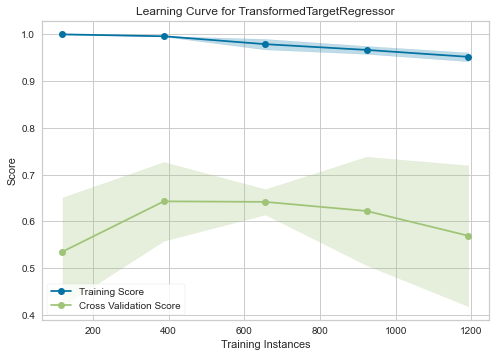

<AxesSubplot:title={'center':'Learning Curve for TransformedTargetRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [85]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns


preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)

pipe = Pipeline(steps=[("preprocessor", preprocessor), ("xgboost", xgboost.XGBRegressor())])
model = TransformedTargetRegressor(regressor=pipe, func=np.log, inverse_func=np.exp)

visualizer_lear = LearningCurve(model, scoring='r2')

visualizer_lear.fit(X, y)
visualizer_lear.show()

##### 3.1.4.2 Feature importance

Text(0.5, 0, 'Feature Name')

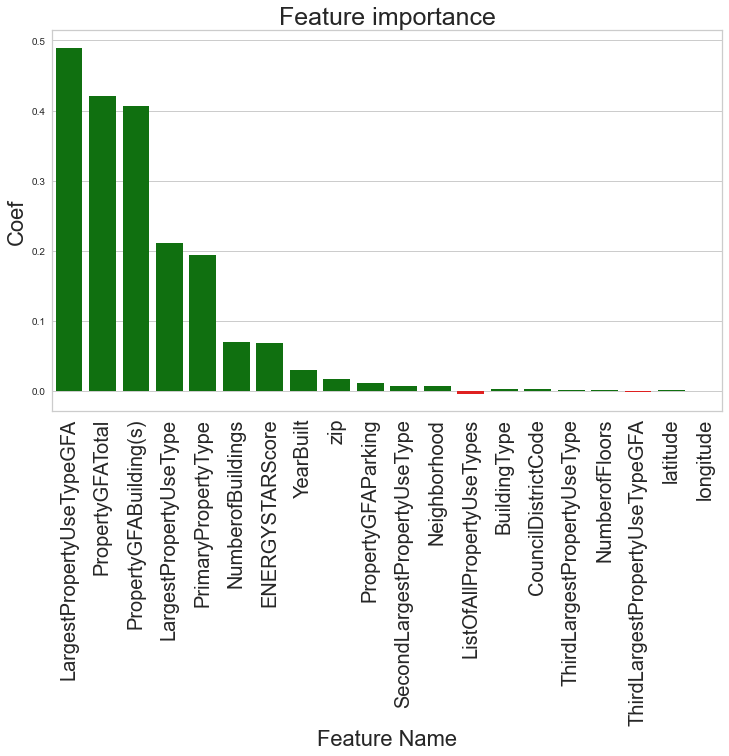

In [33]:
reg.feature_importance( X_test, y_test, X_train, best_model_pipe)

### 3.2 Parameters Tuning

In [34]:
class TuningRegressor:
    def __init__(self, regressor, search_space=None, random_state=42): 
        self.regressor = regressor
        self.search_space = search_space
        self.name = regressor.__name__
        self.random_state = random_state

    def hyperparameter_tuning(self, args):
        
        pipe = Pipeline(steps=[("preprocessor", preprocessor), (self.name, self.regressor(**args))])
        model = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        r_squared = r2_score(y_test, y_pred)
        adj_rsquared = adjusted_rsquared(
                       r_squared, X_test.shape[0], X_test.shape[1])
        return {'loss': -r_squared, 'status': STATUS_OK, 'model': model}

    def optimisation(self):
        best_params= {}
        if self.search_space : 
            trials = Trials()
            best_params = fmin(fn=self.hyperparameter_tuning,
                                space=self.search_space,
                                algo=tpe.suggest,
                                max_evals=50,
                                trials=trials, 
                                verbose=1, 
                                rstate=np.random.RandomState(self.random_state))
            best_params = space_eval(self.search_space, best_params)
            fnvals = [t['result']['loss'] for t in trials.trials]
            best_loss = min(fnvals)
            
        return best_params, best_loss
    
def benchmark(models_params):
    params = {}
    losses = {}
    for regressor, search_params in models_params.items():
        best_params, best_loss = TuningRegressor(regressor=regressor, search_space=search_params).optimisation()
        params[regressor.__name__] = best_params
        losses[regressor.__name__] = best_loss
    best_model = min(losses, key=losses.get)
    print(f'{best_model} is the best model with a loss of {losses[best_model]}')
    return params[best_model]

In [35]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns


preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)
models_params = {xgboost.XGBRegressor:{'max_depth': hp.choice("max_depth", range(5, 20, 1)), # default 6
                                        'gamma': hp.uniform('gamma',1 , 9),                # default 0
                                        'reg_alpha' : hp.quniform('reg_alpha', 0, 180, 5),     # default 0
                                        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),        # default 1
                                        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),       # default 1
                                        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),# default 1
                                       'booster':hp.choice("booster", ["gbtree", "dart"]),
                                        'objective':hp.choice("objective", ['reg:squaredlogerror', 'reg:squarederror']), 
                                       'n_estimators': hp.choice('n_estimators', range(100, 200, 30)),
                                       'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.01 )},
                xgboost.XGBRFRegressor:{'max_depth': hp.choice("max_depth", range(5, 20, 1)), # default 6
                                        'gamma': hp.uniform('gamma',0 , 9),                # default 0
                                        'reg_alpha' : hp.quniform('reg_alpha', 0, 180, 5),     # default 0
                                        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),        # default 1
                                        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),       # default 1
                                        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),# default 1
                                       'booster':hp.choice("booster", ["gbtree", "dart"]),
                                        'objective':hp.choice("objective", ['reg:squaredlogerror', 'reg:squarederror']), 
                                       'n_estimators': hp.choice('n_estimators', range(100, 200, 30)),
                                       'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.01 ), #defaul 0.3
                                      },
                SVR: {'C': hp.choice('C', np.arange(0.005,2.0,0.01)),
                      'kernel': hp.choice('kernel',['linear', 'poly', 'rbf']),
                      'degree':hp.choice('degree',np.arange(1, 6, 1)),
                      'epsilon':hp.choice('epsilon',np.arange(0.05, 1, 0.05)),
                      'coef0':hp.choice('coef0',np.arange(0.0, 1, 0.05))
                      }}
params = benchmark(models_params)

100%|███████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/trial, best loss: -0.6387894377013722]
XGBRegressor is the best model with a loss of -0.771794868647684


### 3.3 Plot best model

In [86]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns


preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)

pipe = Pipeline(steps=[("preprocessor", preprocessor), ("xgboost", xgboost.XGBRegressor(**params))])
model = TransformedTargetRegressor(regressor=pipe, func=np.log, inverse_func=np.exp)

#### 3.3.1 Residual plot

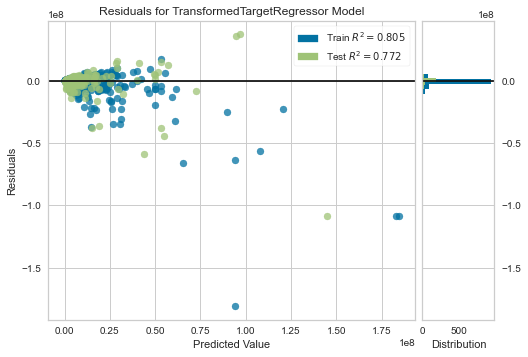

<AxesSubplot:title={'center':'Residuals for TransformedTargetRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [62]:
visualizer_res = ResidualsPlot(model)

visualizer_res.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer_res.score(X_test, y_test)  # Evaluate the model on the test data
visualizer_res.show() 

#### 3.3.2 Scatter plot

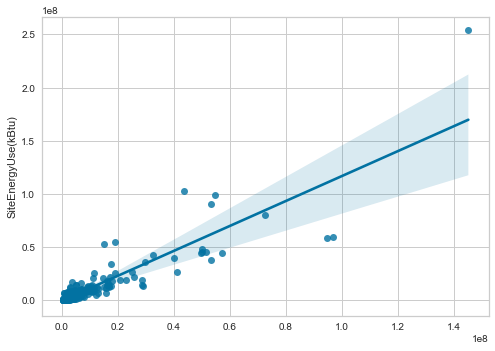

In [88]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.regplot(x=y_pred, y=y_test, fit_reg=True)
plt.show()

#### 3.3.2 Learning Curve

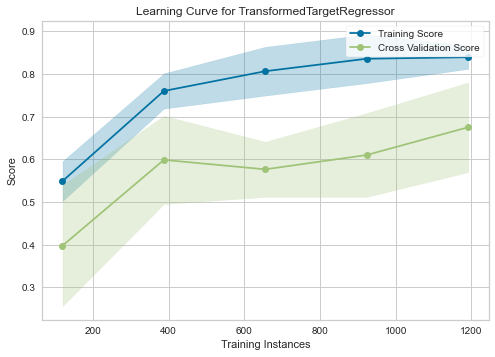

<AxesSubplot:title={'center':'Learning Curve for TransformedTargetRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [63]:
visualizer_lear = LearningCurve(model, scoring='r2')

visualizer_lear.fit(X, y)
visualizer_lear.show()

## 4. Prediction of TotalGHGEmissions

### 4.1 Prediction with EnergyStarScore 

In [70]:
REGRESSORS = [("XGBRegressor", xgboost.XGBRegressor)]

df = pd.read_pickle('data/clean_data.pkl')
df = df[df['TotalGHGEmissions'] > 0]

categorical_features = df.select_dtypes(include=["object"]).columns
df[categorical_features] = df[categorical_features].astype(str)

X = df.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])
y = df['TotalGHGEmissions']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2, random_state=123)

In [71]:
reg = Regressors(verbose=1, regressors=REGRESSORS, params=params)
regressions_energystar, best_model_pipe_energy = reg.fit(X_train, X_test, y_train, y_test)
regressions_energystar['ENERGYSTAR'] = True

{'booster': 'gbtree', 'colsample_bytree': 0.7243225941883278, 'gamma': 1.6163255956364715, 'learning_rate': 0.1, 'max_depth': 11, 'min_child_weight': 2.0, 'n_estimators': 100, 'objective': 'reg:squarederror', 'reg_alpha': 0.0, 'reg_lambda': 0.21549816129044064}
'tuple' object has no attribute '__name__'
Invalid Regressor(s)
[('XGBRegressor', <class 'xgboost.sklearn.XGBRegressor'>)]


100%|███████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.8545919428887588, 'Adjusted R-Squared': 0.8430848304554952, 'RMSE': 284.5932720860406, 'Time taken': 2.331254005432129}


Text(0.5, 0, 'Feature Name')

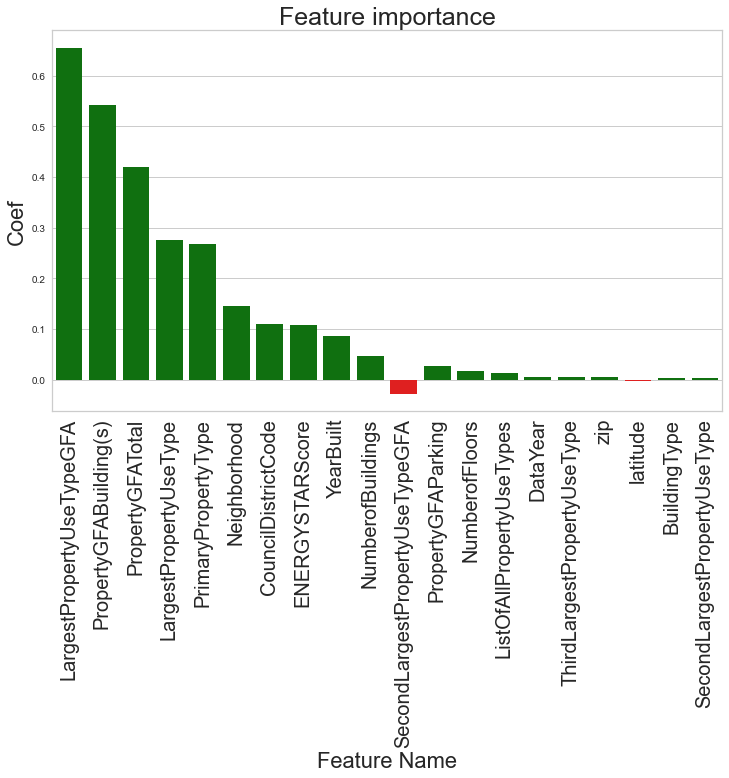

In [42]:
reg.feature_importance( X_test, y_test, X_train, best_model_pipe_energy)

In [43]:
X_train = X_train.drop(columns=['ENERGYSTARScore'])
X_test = X_test.drop(columns=['ENERGYSTARScore'])


regressions, best_model_pipe_no_energy = reg.fit(X_train, X_test, y_train, y_test)
regressions['ENERGYSTAR'] = False

'tuple' object has no attribute '__name__'
Invalid Regressor(s)
[('XGBRegressor', <class 'xgboost.sklearn.XGBRegressor'>)]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.7878039313176601, 'Adjusted R-Squared': 0.7718321842125377, 'RMSE': 343.7946071296826, 'Time taken': 1.664656162261963}


Text(0.5, 0, 'Feature Name')

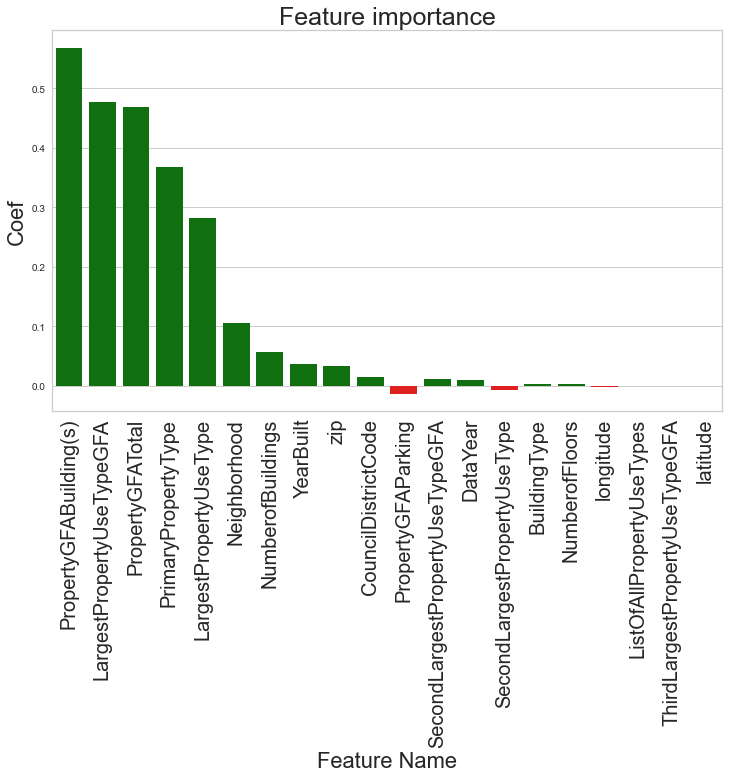

In [44]:
reg.feature_importance( X_test, y_test, X_train, best_model_pipe_no_energy)

In [45]:
regressions = pd.concat([regressions_energystar, regressions])
regressions.reset_index().style.highlight_max(subset='Adjusted R-Squared', color='green')

,Model,Adjusted R-Squared,R-Squared,RMSE,Time Taken,ENERGYSTAR
0,XGBRegressor,84.310000,85.460000,284.593272,1.631380,True
1,XGBRegressor,77.180000,78.780000,343.794607,1.664656,False


### 4.2 Visualize model with ENERGYSTARSCORE

In [90]:
df = pd.read_pickle('data/clean_data.pkl')
df = df[df['TotalGHGEmissions'] > 0]

categorical_features = df.select_dtypes(include=["object"]).columns
df[categorical_features] = df[categorical_features].astype(str)

X = df.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])
y = df['TotalGHGEmissions']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2, random_state = 123)

In [91]:
pipe = Pipeline(steps=[("preprocessor", preprocessor), ("xgboost", xgboost.XGBRegressor(**params))])
model = TransformedTargetRegressor(regressor=pipe, func=np.log, inverse_func=np.exp)

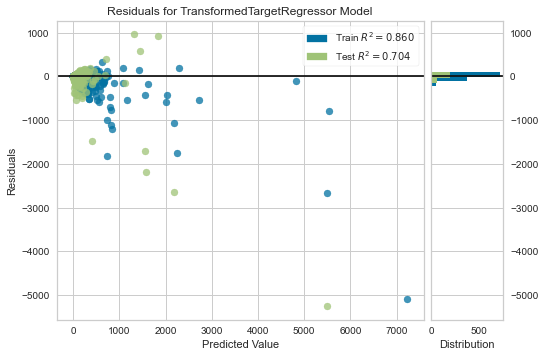

<AxesSubplot:title={'center':'Residuals for TransformedTargetRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [92]:
visualizer_res = ResidualsPlot(model)

visualizer_res.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer_res.score(X_test, y_test)  # Evaluate the model on the test data
visualizer_res.show() 

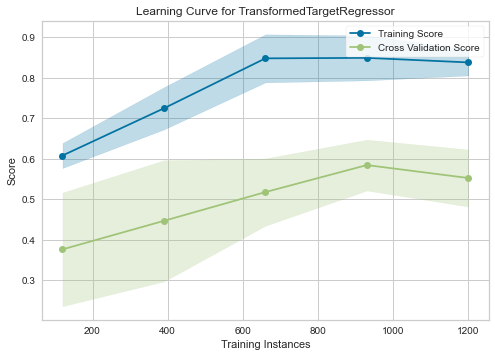

<AxesSubplot:title={'center':'Learning Curve for TransformedTargetRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [93]:
visualizer_lear = LearningCurve(model, scoring='r2')

visualizer_lear.fit(X, y)
visualizer_lear.show()